# TCGA PANCAN Multi-Omics Data Loading and Cox Regression Feature Engineering

This notebook implements comprehensive loading and preprocessing of TCGA PANCAN multi-omics data with Cox regression analysis for feature engineering.

## Data Files Structure:
1. **Transcriptome**: `unc.edu_PANCAN_IlluminaHiSeq_RNASeqV2.geneExp_whitelisted.tsv` (log2 transformed)
2. **Copy Number Variation**: `CNV.GISTIC_call.all_data_by_genes_whitelisted.tsv` (log2 transformed)
3. **microRNA**: `bcgsc.ca_PANCAN_IlluminaHiSeq_miRNASeq.miRNAExp_whitelisted.tsv` (log2 transformed)
4. **RPPA**: `mdanderson.org_PANCAN_MDA_RPPA_Core.RPPA_whitelisted.tsv` (log2 transformed)
5. **Methylation**: `jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.csv` (NO transformation, for tab-transformer)
6. **Mutations**: `tcga_pancancer_082115.vep.filter_whitelisted.maf.gz` (impact scores, NO transformation)
7. **Clinical**: `clinical_PANCAN_patient_with_followup.tsv`

## Output:
- Cox coefficient lookup tables
- Processed multi-omics data (patient × features)
- Methylation data for tab-transformer
- Feature importance rankings
- Data quality reports

## 1. Environment Setup and Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import gzip
from tqdm import tqdm
import pickle
import warnings
import json
import os
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from collections import defaultdict

# 병렬처리를 위한 라이브러리 추가
from multiprocessing import Pool, cpu_count
from functools import partial
import concurrent.futures

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

# Define paths
DATA_RAW_PATH = Path('../data/raw')
DATA_PROCESSED_PATH = Path('../data/processed')
RESULTS_PATH = Path('../results')

# Create directories if they don't exist
DATA_PROCESSED_PATH.mkdir(exist_ok=True)
RESULTS_PATH.mkdir(exist_ok=True)

print("Environment setup complete!")
print(f"Raw data path: {DATA_RAW_PATH}")
print(f"Processed data path: {DATA_PROCESSED_PATH}")
print(f"Results path: {RESULTS_PATH}")
print(f"Available CPU cores: {cpu_count()}")

Environment setup complete!
Raw data path: ../data/raw
Processed data path: ../data/processed
Results path: ../results
Available CPU cores: 80


## 2. Data Loading Functions

In [3]:
def standardize_patient_id(patient_id):
    """Standardize TCGA patient IDs to 12-character format (TCGA-XX-XXXX)"""
    if isinstance(patient_id, str):
        # Remove any trailing parts after the sample type (e.g., -01A, -11A)
        parts = patient_id.split('-')
        if len(parts) >= 3:
            return f"{parts[0]}-{parts[1]}-{parts[2]}"
    return patient_id

def filter_primary_samples(data):
    """
    Filter TCGA data to keep only primary tumor samples
    
    TCGA Sample Types (4th part of barcode):
    - 01: Primary Solid Tumor (원발성 고형암)
    - 03: Primary Blood Derived Cancer - Peripheral Blood (원발성 혈액암 - 말초혈액)
    - 09: Primary Blood Derived Cancer - Bone Marrow (원발성 혈액암 - 골수)
    """
    primary_sample_types = ['01', '03', '09']
    
    # Extract sample type from full barcode
    def get_sample_type(barcode):
        parts = str(barcode).split('-')
        if len(parts) >= 4:
            return parts[3][:2]  # First 2 digits of 4th part
        return None
    
    # Filter for primary samples only
    sample_types = data.index.map(get_sample_type)
    primary_mask = sample_types.isin(primary_sample_types)
    
    before_count = len(data)
    filtered_data = data[primary_mask]
    after_count = len(filtered_data)
    
    print(f"  원발성 암 필터링: {before_count} → {after_count} 샘플 ({before_count - after_count}개 제거)")
    
    return filtered_data

def load_transcriptome_data(file_path):
    """Load and preprocess transcriptome data with log2 transformation"""
    print("Loading transcriptome data...")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Parse gene symbols from first column (Gene_Symbol|Entrez_ID)
    gene_info = df.index.str.split('|', expand=True)
    
    # Handle potential IndexError
    if hasattr(gene_info, 'shape') and len(gene_info.shape) > 1 and gene_info.shape[1] >= 2:
        gene_symbols = gene_info.iloc[:, 0]
        entrez_ids = gene_info.iloc[:, 1]
        gene_symbols = gene_symbols.where(gene_symbols != '?', 'Gene_' + entrez_ids.astype(str))
    else:
        # No "|" separator found, use original index
        gene_symbols = df.index
        print("Gene symbols not split - using original index")
    
    # Set gene symbols as index
    df.index = gene_symbols
    
    # Transpose to get patients as rows
    df = df.T
    
    # Filter for primary tumor samples only
    df = filter_primary_samples(df)
    
    # Standardize patient IDs
    df.index = [standardize_patient_id(pid) for pid in df.index]
    
    # Remove duplicated patients (keep first occurrence)
    df = df[~df.index.duplicated(keep='first')]
    
    # Store original values for comparison
    original_stats = {
        'mean': df.values.mean(),
        'std': df.values.std(),
        'min': df.values.min(),
        'max': df.values.max(),
        'zeros': (df.values == 0).sum()
    }
    
    # Apply log2 transformation: log2(x + 1)
    df_log = np.log2(df + 1)
    
    # Store transformed stats
    transformed_stats = {
        'mean': df_log.values.mean(),
        'std': df_log.values.std(),
        'min': df_log.values.min(),
        'max': df_log.values.max(),
        'zeros': (df_log.values == 0).sum()
    }
    
    transformation_stats = {
        'original': original_stats,
        'transformed': transformed_stats,
        'n_patients': df_log.shape[0],
        'n_genes': df_log.shape[1]
    }
    
    print(f"Transcriptome data loaded: {df_log.shape[0]} patients × {df_log.shape[1]} genes (log2 transformed)")
    
    return df_log, transformation_stats

def load_cnv_data(file_path):
    """Load and preprocess CNV data with log2 transformation"""
    print("Loading CNV data...")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t')
    
    # Skip first 3 annotation columns and set gene symbol as index
    gene_symbols = df.iloc[:, 0]  # First column is Gene Symbol
    df_values = df.iloc[:, 3:]  # Skip first 3 columns (Gene Symbol, Locus ID, Cytoband)
    df_values.index = gene_symbols
    
    # Transpose to get patients as rows
    df_values = df_values.T
    
    # Filter for primary tumor samples only
    df_values = filter_primary_samples(df_values)
    
    # Standardize patient IDs
    df_values.index = [standardize_patient_id(pid) for pid in df_values.index]
    
    # Remove duplicated patients (keep first occurrence)
    df_values = df_values[~df_values.index.duplicated(keep='first')]
    
    # Apply log2 transformation: log2(x + 1) for positive values, handle negatives
    min_val = df_values.values.min()
    if min_val < 0:
        # Shift negative values to make all positive before log transformation
        df_log = np.log2(df_values - min_val + 1)
        print(f"Applied log2(x - {min_val:.3f} + 1) transformation for negative CNV values")
    else:
        df_log = np.log2(df_values + 1)
        print("Applied log2(x + 1) transformation")
    
    print(f"CNV data loaded: {df_log.shape[0]} patients × {df_log.shape[1]} genes (log2 transformed)")
    
    return df_log

def load_mirna_data(file_path):
    """Load and preprocess microRNA data with log2 transformation"""
    print("Loading microRNA data...")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Transpose to get patients as rows
    df = df.T
    
    # Filter for primary tumor samples only
    df = filter_primary_samples(df)
    
    # Standardize patient IDs
    df.index = [standardize_patient_id(pid) for pid in df.index]
    
    # Remove duplicated patients (keep first occurrence)
    df = df[~df.index.duplicated(keep='first')]
    
    # Apply log2 transformation: log2(x + 1)
    df_log = np.log2(df + 1)
    
    print(f"microRNA data loaded: {df_log.shape[0]} patients × {df_log.shape[1]} miRNAs (log2 transformed)")
    
    return df_log

def load_rppa_data(file_path):
    """Load and preprocess RPPA protein data with log2 transformation"""
    print("Loading RPPA data...")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Transpose to get patients as rows
    df = df.T
    
    # Filter for primary tumor samples only
    df = filter_primary_samples(df)
    
    # Standardize patient IDs
    df.index = [standardize_patient_id(pid) for pid in df.index]
    
    # Remove duplicated patients (keep first occurrence)
    df = df[~df.index.duplicated(keep='first')]
    
    # Apply log2 transformation: log2(x + 1) for positive values, handle negatives
    min_val = df.values.min()
    if min_val < 0:
        # Shift negative values to make all positive before log transformation
        df_log = np.log2(df - min_val + 1)
        print(f"Applied log2(x - {min_val:.3f} + 1) transformation for negative RPPA values")
    else:
        df_log = np.log2(df + 1)
        print("Applied log2(x + 1) transformation")
    
    print(f"RPPA data loaded: {df_log.shape[0]} patients × {df_log.shape[1]} proteins (log2 transformed)")
    
    return df_log

def load_methylation_data(file_path):
    """Load methylation data for tab-transformer (NO log2 transformation)"""
    print("Loading methylation data...")
    print("Note: NO log2 transformation applied - beta values (0-1) for tab-transformer")
    
    # Load data - try both .csv and .tsv extensions
    try:
        df = pd.read_csv(file_path, sep='\t', index_col=0)
    except FileNotFoundError:
        # Try with .csv extension
        csv_path = str(file_path).replace('.tsv', '.csv')
        df = pd.read_csv(csv_path, sep='\t', index_col=0)
    
    # Transpose to get patients as rows
    df = df.T
    
    # Filter for primary tumor samples only
    df = filter_primary_samples(df)
    
    # Standardize patient IDs
    df.index = [standardize_patient_id(pid) for pid in df.index]
    
    # Remove duplicated patients (keep first occurrence)
    df = df[~df.index.duplicated(keep='first')]
    
    # Check data quality
    missing_values = df.isna().sum().sum()
    total_values = df.shape[0] * df.shape[1]
    missing_percentage = (missing_values / total_values) * 100
    
    print(f"Methylation data loaded: {df.shape[0]} patients × {df.shape[1]} probes")
    print(f"Missing values: {missing_values:,} ({missing_percentage:.2f}% of total)")
    print("This data is prepared for tab-transformer network (beta values preserved)")
    
    return df

def load_mutation_data(file_path):
    """Load and preprocess mutation data from MAF format (NO log2 transformation)"""
    print("Loading mutation data...")
    print("Note: Impact scores (0-2), NO log2 transformation")
    
    # Load MAF file with encoding handling, skipping the version line
    try:
        with gzip.open(file_path, 'rt', encoding='utf-8') as f:
            # Skip the first line (#version 2.4)
            first_line = f.readline()
            if first_line.startswith('#version'):
                # Read the rest of the file
                df = pd.read_csv(f, sep='\t', low_memory=False)
            else:
                # Reset file pointer and read normally
                f.seek(0)
                df = pd.read_csv(f, sep='\t', low_memory=False)
    except UnicodeDecodeError:
        with gzip.open(file_path, 'rt', encoding='latin-1') as f:
            first_line = f.readline()
            if first_line.startswith('#version'):
                df = pd.read_csv(f, sep='\t', low_memory=False)
            else:
                f.seek(0)
                df = pd.read_csv(f, sep='\t', low_memory=False)
    
    print(f"Raw MAF data: {df.shape[0]} mutations")
    
    # Filter for primary tumor samples only
    def get_sample_type_from_barcode(barcode):
        parts = str(barcode).split('-')
        if len(parts) >= 4:
            return parts[3][:2]
        return None
    
    primary_sample_types = ['01', '03', '09']
    sample_types = df['Tumor_Sample_Barcode'].map(get_sample_type_from_barcode)
    primary_mask = sample_types.isin(primary_sample_types)
    
    before_count = len(df)
    df = df[primary_mask]
    after_count = len(df)
    print(f"  원발성 암 필터링: {before_count} → {after_count} 돌연변이 ({before_count - after_count}개 제거)")
    
    # Define mutation impact scoring
    variant_impact = {
        'Silent': 0,
        'Missense_Mutation': 1,
        'Nonsense_Mutation': 2,
        'Frame_Shift_Del': 2,
        'Frame_Shift_Ins': 2,
        'Splice_Site': 2,
        'Translation_Start_Site': 1,
        'Nonstop_Mutation': 1,
        'In_Frame_Del': 1,
        'In_Frame_Ins': 1,
        "3'UTR": 0,
        "5'UTR": 0,
        'Intron': 0,
        'RNA': 0
    }
    
    # Filter for relevant columns
    required_cols = ['Hugo_Symbol', 'Tumor_Sample_Barcode', 'Variant_Classification']
    if not all(col in df.columns for col in required_cols):
        print(f"Missing required columns. Available columns: {list(df.columns[:10])}...")
        return pd.DataFrame()
    
    # Standardize patient IDs
    df['Patient_ID'] = df['Tumor_Sample_Barcode'].apply(standardize_patient_id)
    
    # Map variant classifications to impact scores
    df['Impact_Score'] = df['Variant_Classification'].map(variant_impact).fillna(0)
    
    # Aggregate mutations per patient-gene pair (take maximum impact)
    mutation_matrix = df.groupby(['Patient_ID', 'Hugo_Symbol'])['Impact_Score'].max().unstack(fill_value=0)
    
    print(f"Mutation matrix: {mutation_matrix.shape[0]} patients × {mutation_matrix.shape[1]} genes (impact scores)")
    
    return mutation_matrix

def load_clinical_data(file_path):
    """Load and preprocess clinical data"""
    print("Loading clinical data...")
    
    # Try different encodings to handle problematic characters
    encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    
    df = None
    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(file_path, sep='\t', encoding=encoding, low_memory=False)
            print(f"Successfully loaded clinical data with {encoding} encoding")
            break
        except UnicodeDecodeError:
            continue
    
    if df is None:
        # Last resort: ignore problematic characters
        df = pd.read_csv(file_path, sep='\t', encoding='utf-8', errors='ignore', low_memory=False)
        print("Loaded clinical data with UTF-8 encoding, ignoring problematic characters")
    
    # Standardize patient IDs
    df['bcr_patient_barcode'] = df['bcr_patient_barcode'].apply(standardize_patient_id)
    
    # Set patient ID as index
    df = df.set_index('bcr_patient_barcode')
    
    print(f"Clinical data loaded: {df.shape[0]} patients × {df.shape[1]} features")
    
    return df

def clean_survival_data(clinical_df):
    """생존 데이터를 정리하여 올바른 숫자형으로 변환"""
    
    print("=== 생존 데이터 정리 ===")
    print()
    
    clinical_clean = clinical_df.copy()
    
    # 1. days_to_death 정리
    print("1. days_to_death 정리:")
    death_col = clinical_clean['days_to_death'].copy()
    
    # 비수치 값들을 NaN으로 변환
    invalid_death = death_col.isin(['[Not Applicable]', '[Not Available]', '[Discrepancy]', '[Unknown]'])
    print(f"   • 비수치 값: {invalid_death.sum()}개 → NaN으로 변환")
    
    death_col[invalid_death] = np.nan
    death_col = pd.to_numeric(death_col, errors='coerce')
    clinical_clean['days_to_death_clean'] = death_col
    
    # 2. days_to_last_followup 정리
    print("2. days_to_last_followup 정리:")
    followup_col = clinical_clean['days_to_last_followup'].copy()
    
    invalid_followup = followup_col.isin(['[Not Applicable]', '[Not Available]', '[Discrepancy]', '[Unknown]'])
    print(f"   • 비수치 값: {invalid_followup.sum()}개 → NaN으로 변환")
    
    followup_col[invalid_followup] = np.nan
    followup_col = pd.to_numeric(followup_col, errors='coerce')
    
    # 음수값 제거 (잘못된 데이터)
    negative_followup = followup_col < 0
    print(f"   • 음수 값: {negative_followup.sum()}개 → NaN으로 변환")
    followup_col[negative_followup] = np.nan
    
    clinical_clean['days_to_last_followup_clean'] = followup_col
    
    # 3. vital_status 정리
    print("3. vital_status 정리:")
    vital_status_counts = clinical_clean['vital_status'].value_counts()
    print(f"   • {vital_status_counts.to_dict()}")
    
    # 올바른 vital_status만 유지
    valid_vital_status = clinical_clean['vital_status'].isin(['Alive', 'Dead'])
    print(f"   • 유효한 vital_status: {valid_vital_status.sum()}개")
    
    # 4. 새로운 생존 시간과 이벤트 생성
    print("4. 새로운 survival_time과 survival_event 생성:")
    
    # survival_time 재계산
    survival_time_new = np.where(
        (clinical_clean['vital_status'] == 'Dead') & clinical_clean['days_to_death_clean'].notna(),
        clinical_clean['days_to_death_clean'],
        clinical_clean['days_to_last_followup_clean']
    )
    
    # survival_event 재계산
    survival_event_new = (clinical_clean['vital_status'] == 'Dead').astype(int)
    
    # 유효하지 않은 vital_status는 제외
    survival_event_new[~valid_vital_status] = np.nan
    survival_time_new[~valid_vital_status] = np.nan
    
    clinical_clean['survival_time_clean'] = survival_time_new
    clinical_clean['survival_event_clean'] = survival_event_new
    
    # 5. 유효한 생존 데이터만 남기기
    valid_survival = (
        pd.notna(clinical_clean['survival_time_clean']) & 
        pd.notna(clinical_clean['survival_event_clean']) &
        (clinical_clean['survival_time_clean'] >= 0)
    )
    
    print(f"   • 유효한 생존 데이터: {valid_survival.sum()}개")
    print(f"   • 사망 이벤트: {clinical_clean.loc[valid_survival, 'survival_event_clean'].sum()}개")
    print(f"   • 평균 생존 시간: {clinical_clean.loc[valid_survival, 'survival_time_clean'].mean():.1f}일")
    
    return clinical_clean, valid_survival

## 3. Load All Data

In [4]:
# Load all datasets
print("=" * 60)
print("LOADING TCGA PANCAN MULTI-OMICS DATA")
print("=" * 60)

# Load transcriptome data (log2 transformed)
expression_data, transformation_stats = load_transcriptome_data(
    DATA_RAW_PATH / 'unc.edu_PANCAN_IlluminaHiSeq_RNASeqV2.geneExp_whitelisted.tsv'
)

# Load CNV data (log2 transformed)
cnv_data = load_cnv_data(
    DATA_RAW_PATH / 'CNV.GISTIC_call.all_data_by_genes_whitelisted.tsv'
)

# Load microRNA data (log2 transformed)
mirna_data = load_mirna_data(
    DATA_RAW_PATH / 'bcgsc.ca_PANCAN_IlluminaHiSeq_miRNASeq.miRNAExp_whitelisted.tsv'
)

# Load RPPA data (log2 transformed)
rppa_data = load_rppa_data(
    DATA_RAW_PATH / 'mdanderson.org_PANCAN_MDA_RPPA_Core.RPPA_whitelisted.tsv'
)

# Load methylation data (NO transformation - for tab-transformer)
methylation_data = load_methylation_data(
    DATA_RAW_PATH / 'jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv'
)

# Load mutation data (impact scores - NO transformation)
mutation_data = load_mutation_data(
    DATA_RAW_PATH / 'tcga_pancancer_082115.vep.filter_whitelisted.maf.gz'
)

# Load clinical data
clinical_data = load_clinical_data(
    DATA_RAW_PATH / 'clinical_PANCAN_patient_with_followup.tsv'
)

print("\n" + "=" * 60)
print("DATA LOADING SUMMARY")
print("=" * 60)
print(f"Expression: {expression_data.shape[0]} patients × {expression_data.shape[1]} genes (log2 transformed)")
print(f"CNV: {cnv_data.shape[0]} patients × {cnv_data.shape[1]} genes (log2 transformed)")
print(f"microRNA: {mirna_data.shape[0]} patients × {mirna_data.shape[1]} miRNAs (log2 transformed)")
print(f"RPPA: {rppa_data.shape[0]} patients × {rppa_data.shape[1]} proteins (log2 transformed)")
print(f"Methylation: {methylation_data.shape[0]} patients × {methylation_data.shape[1]} probes (NO transformation)")
print(f"Mutations: {mutation_data.shape[0]} patients × {mutation_data.shape[1]} genes (impact scores)")
print(f"Clinical: {clinical_data.shape[0]} patients × {clinical_data.shape[1]} features")

LOADING TCGA PANCAN MULTI-OMICS DATA
Loading transcriptome data...
Gene symbols not split - using original index
  원발성 암 필터링: 10327 → 9174 샘플 (1153개 제거)
Transcriptome data loaded: 9170 patients × 20531 genes (log2 transformed)
Loading CNV data...
  원발성 암 필터링: 10713 → 10346 샘플 (367개 제거)
Applied log2(x - -1.290 + 1) transformation for negative CNV values
CNV data loaded: 10346 patients × 25128 genes (log2 transformed)
Loading microRNA data...
  원발성 암 필터링: 9350 → 8285 샘플 (1065개 제거)
microRNA data loaded: 8284 patients × 1071 miRNAs (log2 transformed)
Loading RPPA data...
  원발성 암 필터링: 7656 → 7303 샘플 (353개 제거)
Applied log2(x + 1) transformation
RPPA data loaded: 7296 patients × 387 proteins (log2 transformed)
Loading methylation data...
Note: NO log2 transformation applied - beta values (0-1) for tab-transformer
  원발성 암 필터링: 9664 → 8495 샘플 (1169개 제거)
Methylation data loaded: 8475 patients × 396065 probes
Missing values: 3,571,734 (0.11% of total)
This data is prepared for tab-transformer net

## 4. Survival Data Cleaning

In [5]:
# 생존 데이터 정리 실행
clinical_data_clean, valid_survival_mask = clean_survival_data(clinical_data)

print()
print("=== 정리 후 검증 ===")
print(f"전체 환자: {len(clinical_data_clean)}")
print(f"유효한 생존 데이터 보유 환자: {valid_survival_mask.sum()}")

# 유효한 생존 데이터를 가진 환자 목록
valid_survival_patients = clinical_data_clean.index[valid_survival_mask]
print(f"유효한 생존 데이터 환자 목록: {len(valid_survival_patients)}명")

=== 생존 데이터 정리 ===

1. days_to_death 정리:
   • 비수치 값: 7487개 → NaN으로 변환
2. days_to_last_followup 정리:
   • 비수치 값: 1872개 → NaN으로 변환
   • 음수 값: 14개 → NaN으로 변환
3. vital_status 정리:
   • {'Alive': 7468, 'Dead': 3483, '[Not Available]': 4, '[Discrepancy]': 1}
   • 유효한 vital_status: 10951개
4. 새로운 survival_time과 survival_event 생성:
   • 유효한 생존 데이터: 10900개
   • 사망 이벤트: 3471.0개
   • 평균 생존 시간: 1042.3일

=== 정리 후 검증 ===
전체 환자: 10956
유효한 생존 데이터 보유 환자: 10900
유효한 생존 데이터 환자 목록: 10900명


## 5. Patient ID Matching and Data Integration

In [6]:
# Analyze patient overlap across datasets
# datasets = {
#     'Expression': set(expression_data.index),
#     'CNV': set(cnv_data.index),
#     'microRNA': set(mirna_data.index),
#     'RPPA': set(rppa_data.index),
#     'Methylation': set(methylation_data.index),
#     'Mutations': set(mutation_data.index),
#     'Clinical': set(valid_survival_patients)  # Only valid survival patients
# }

datasets = {
    'Expression': set(expression_data.index).intersection(set(valid_survival_patients)),
    'CNV': set(cnv_data.index).intersection(set(valid_survival_patients)),
    'microRNA': set(mirna_data.index).intersection(set(valid_survival_patients)),
    'RPPA': set(rppa_data.index).intersection(set(valid_survival_patients)),
    'Methylation': set(methylation_data.index).intersection(set(valid_survival_patients)),
    'Mutations': set(mutation_data.index).intersection(set(valid_survival_patients)),
    'Clinical': set(valid_survival_patients)
}

print("Patient counts per dataset:")
for name, patients in datasets.items():
    print(f"{name}: {len(patients)} patients")

# Cox 회귀용 환자들 (메틸레이션 제외, 최대한 많은 환자 활용)
cox_datasets = {k: v for k, v in datasets.items() if k != 'Methylation'}
cox_patients = set.intersection(*cox_datasets.values())
print(f"\nCox analysis patients (excluding methylation): {len(cox_patients)}")

# 메틸레이션용 환자들 (생존 데이터가 있는 메틸레이션 환자들)
methylation_patients = datasets['Methylation'].intersection(datasets['Clinical'])
print(f"Methylation patients (with survival data): {len(methylation_patients)}")

# 두 모델 모두 사용 가능한 환자들 (최종 예측 시 사용)
combined_patients = cox_patients.intersection(methylation_patients)
print(f"Patients available for both models: {len(combined_patients)}")

# Convert to sorted lists for pandas indexing
final_cox_patients = sorted(list(cox_patients))
final_methylation_patients = sorted(list(methylation_patients))
final_combined_patients = sorted(list(combined_patients))

print(f"\n=== 최종 환자 수 정리 ===")
print(f"Cox 분석 대상: {len(final_cox_patients)} 환자")
print(f"메틸레이션 (tab-transformer용): {len(final_methylation_patients)} 환자")
print(f"두 모델 결합 가능: {len(final_combined_patients)} 환자")

# Cox 분석용 최종 환자 리스트 
final_patient_list_clean = final_cox_patients
print(f"최종 Cox 분석 대상: {len(final_patient_list_clean)} 환자")

Patient counts per dataset:
Expression: 8938 patients
CNV: 10081 patients
microRNA: 8233 patients
RPPA: 7243 patients
Methylation: 8224 patients
Mutations: 8075 patients
Clinical: 10900 patients

Cox analysis patients (excluding methylation): 4504
Methylation patients (with survival data): 8224
Patients available for both models: 4151

=== 최종 환자 수 정리 ===
Cox 분석 대상: 4504 환자
메틸레이션 (tab-transformer용): 8224 환자
두 모델 결합 가능: 4151 환자
최종 Cox 분석 대상: 4504 환자


## 6. Data Quality Visualization

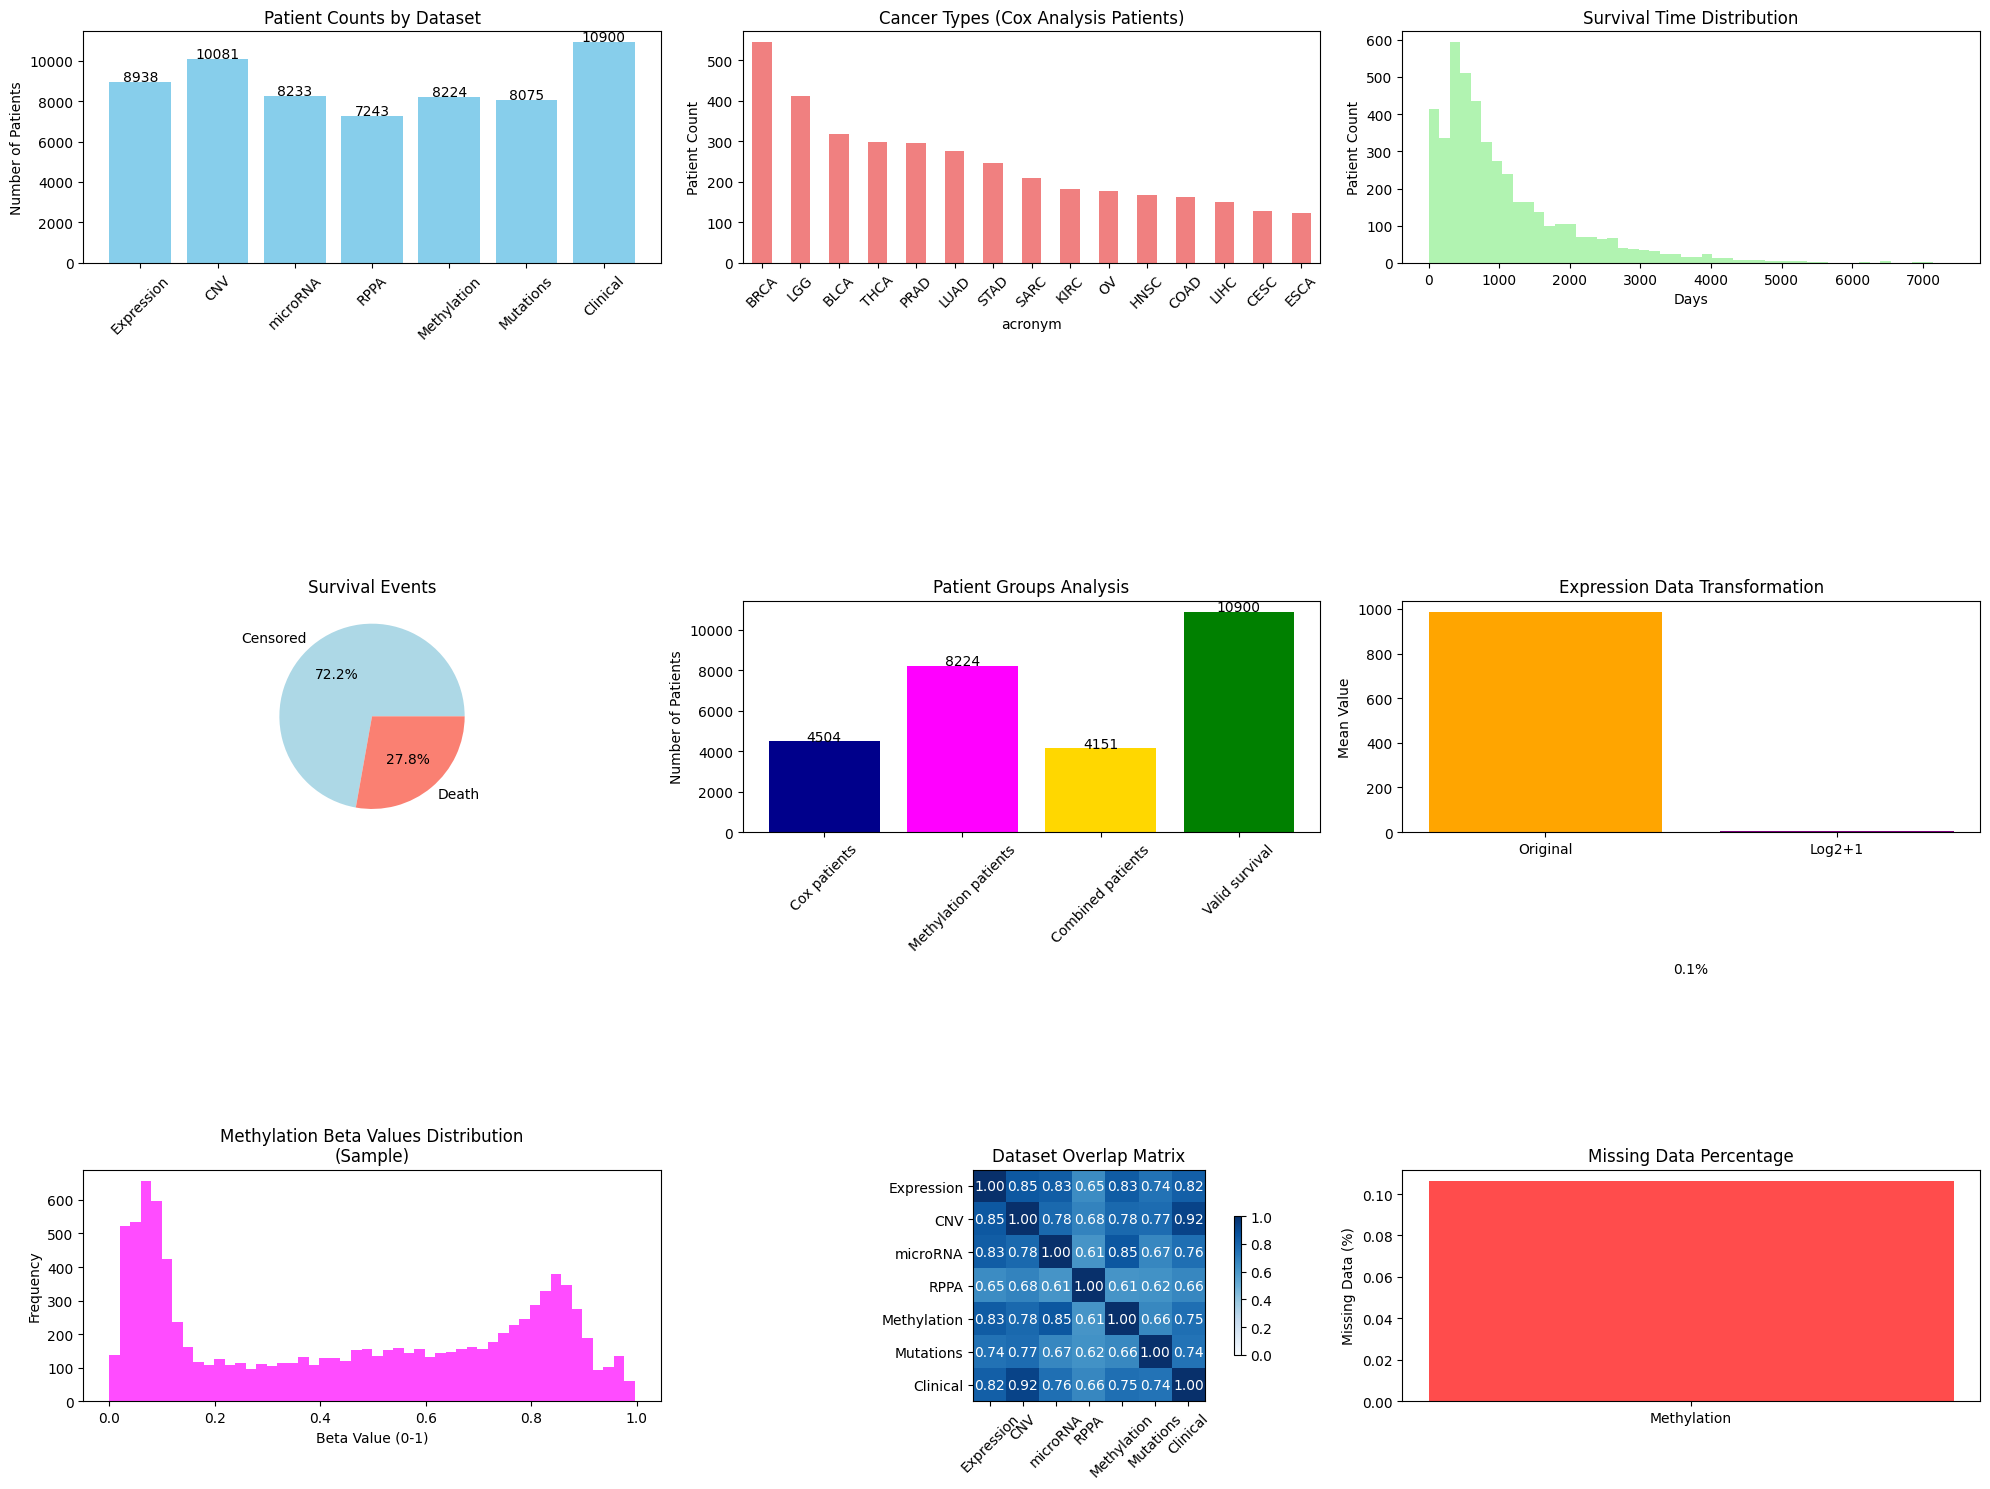


Expression Data Transformation Statistics:
Original data - Mean: 988.322, Std: 6921.912
Transformed data - Mean: 6.406, Std: 4.075
Zero values - Original: 27490533, Transformed: 27490533

Data Integration Summary:
• Total datasets: 7
• Log2 transformed: Expression, CNV, microRNA, RPPA
• NO transformation: Methylation (beta values), Mutations (impact scores)
• Cox analysis patients: 4504
• Methylation patients: 8224
• Combined capability: 4151 patients


In [7]:
# Create data quality visualization
plt.figure(figsize=(20, 15))

# Plot patient counts
plt.subplot(3, 3, 1)
dataset_counts = [len(patients) for patients in datasets.values()]
plt.bar(range(len(datasets)), dataset_counts, color='skyblue')
plt.xticks(range(len(datasets)), list(datasets.keys()), rotation=45)
plt.title('Patient Counts by Dataset')
plt.ylabel('Number of Patients')
for i, count in enumerate(dataset_counts):
    plt.text(i, count + 50, str(count), ha='center')

# Plot cancer type distribution
if 'acronym' in clinical_data_clean.columns:
    plt.subplot(3, 3, 2)
    cancer_counts = clinical_data_clean.loc[final_cox_patients, 'acronym'].value_counts()
    cancer_counts.head(15).plot(kind='bar', color='lightcoral')
    plt.title('Cancer Types (Cox Analysis Patients)')
    plt.xticks(rotation=45)
    plt.ylabel('Patient Count')

# Plot survival data quality
plt.subplot(3, 3, 3)
survival_times = clinical_data_clean.loc[final_cox_patients, 'survival_time_clean']
plt.hist(survival_times.dropna(), bins=50, alpha=0.7, color='lightgreen')
plt.title('Survival Time Distribution')
plt.xlabel('Days')
plt.ylabel('Patient Count')

# Plot survival events
plt.subplot(3, 3, 4)
event_counts = clinical_data_clean.loc[final_cox_patients, 'survival_event_clean'].value_counts()
plt.pie(event_counts.values, labels=['Censored', 'Death'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Survival Events')

# Plot dataset overlap
plt.subplot(3, 3, 5)
overlap_data = {
    'Cox patients': len(final_cox_patients),
    'Methylation patients': len(final_methylation_patients),
    'Combined patients': len(final_combined_patients),
    'Valid survival': len(valid_survival_patients)
}
plt.bar(overlap_data.keys(), overlap_data.values(), color=['darkblue', 'magenta', 'gold', 'green'])
plt.title('Patient Groups Analysis')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
for i, (key, value) in enumerate(overlap_data.items()):
    plt.text(i, value + 20, str(value), ha='center')

# Plot transformation comparison for expression data
plt.subplot(3, 3, 6)
original_mean = transformation_stats['original']['mean']
transformed_mean = transformation_stats['transformed']['mean']
plt.bar(['Original', 'Log2+1'], [original_mean, transformed_mean], color=['orange', 'purple'])
plt.title('Expression Data Transformation')
plt.ylabel('Mean Value')

# Plot methylation data characteristics (use methylation patients)
plt.subplot(3, 3, 7)
if len(final_methylation_patients) > 100:
    meth_sample = methylation_data.loc[final_methylation_patients[:100]].values.flatten()
    meth_sample_clean = meth_sample[~np.isnan(meth_sample)]
    plt.hist(meth_sample_clean[:10000], bins=50, alpha=0.7, color='magenta')
    plt.title('Methylation Beta Values Distribution\n(Sample)')
    plt.xlabel('Beta Value (0-1)')
    plt.ylabel('Frequency')
else:
    plt.text(0.5, 0.5, 'Insufficient methylation data\nfor visualization', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Methylation Data')

# Plot data completeness heatmap
plt.subplot(3, 3, 8)
completeness_matrix = []
dataset_names = list(datasets.keys())
for i, (name1, patients1) in enumerate(datasets.items()):
    row = []
    for j, (name2, patients2) in enumerate(datasets.items()):
        if i == j:
            overlap = 1.0
        else:
            intersection = len(patients1.intersection(patients2))
            union = len(patients1.union(patients2))
            overlap = intersection / union if union > 0 else 0
        row.append(overlap)
    completeness_matrix.append(row)

im = plt.imshow(completeness_matrix, cmap='Blues', vmin=0, vmax=1)
plt.xticks(range(len(dataset_names)), dataset_names, rotation=45)
plt.yticks(range(len(dataset_names)), dataset_names)
plt.title('Dataset Overlap Matrix')
plt.colorbar(im, shrink=0.6)

# Add text annotations
for i in range(len(dataset_names)):
    for j in range(len(dataset_names)):
        plt.text(j, i, f'{completeness_matrix[i][j]:.2f}',
                ha='center', va='center', color='black' if completeness_matrix[i][j] < 0.5 else 'white')

# Plot missing data analysis
plt.subplot(3, 3, 9)
missing_data = {
    'Methylation': (methylation_data.isna().sum().sum() / (methylation_data.shape[0] * methylation_data.shape[1])) * 100
}
plt.bar(missing_data.keys(), missing_data.values(), color='red', alpha=0.7)
plt.title('Missing Data Percentage')
plt.ylabel('Missing Data (%)')
for i, (key, value) in enumerate(missing_data.items()):
    plt.text(i, value + 0.1, f'{value:.1f}%', ha='center')

plt.tight_layout()
plt.show()

# Display transformation statistics
print(f"\nExpression Data Transformation Statistics:")
print(f"Original data - Mean: {transformation_stats['original']['mean']:.3f}, Std: {transformation_stats['original']['std']:.3f}")
print(f"Transformed data - Mean: {transformation_stats['transformed']['mean']:.3f}, Std: {transformation_stats['transformed']['std']:.3f}")
print(f"Zero values - Original: {transformation_stats['original']['zeros']}, Transformed: {transformation_stats['transformed']['zeros']}")

print(f"\nData Integration Summary:")
print(f"• Total datasets: {len(datasets)}")
print(f"• Log2 transformed: Expression, CNV, microRNA, RPPA")
print(f"• NO transformation: Methylation (beta values), Mutations (impact scores)")
print(f"• Cox analysis patients: {len(final_cox_patients)}")
print(f"• Methylation patients: {len(final_methylation_patients)}")
print(f"• Combined capability: {len(final_combined_patients)} patients")

## 7. Cox Regression Analysis Functions

In [15]:
def process_single_feature_cox_safe(args):
    """
    Process a single feature for Cox regression (safer version for multiprocessing)
    
    Parameters:
    - args: tuple containing (feature_name, feature_data, survival_times, survival_events)
    
    Returns:
    - dict with Cox regression results or None if failed
    """
    try:
        feature_name, feature_data, survival_times, survival_events = args
        
        # Create dataframe for Cox regression
        cox_data = pd.DataFrame({
            'T': survival_times,
            'E': survival_events,
            'feature': feature_data
        })
        
        # Remove rows with missing data
        cox_data = cox_data.dropna()
        
        if len(cox_data) < 10:  # Need at least 10 observations for stable results
            return None
        
        # Check for variance in feature
        if cox_data['feature'].var() == 0:
            return None
            
        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(cox_data, duration_col='T', event_col='E')
        
        # Extract results
        coef = cph.summary.loc['feature', 'coef']
        p_value = cph.summary.loc['feature', 'p']
        hr = np.exp(coef)
        ci_lower = np.exp(cph.summary.loc['feature', 'coef lower 95%'])
        ci_upper = np.exp(cph.summary.loc['feature', 'coef upper 95%'])
        
        return {
            'feature': feature_name,
            'coef': float(coef),
            'hr': float(hr),
            'p_value': float(p_value),
            'ci_lower': float(ci_lower),
            'ci_upper': float(ci_upper),
            'n_patients': int(len(cox_data))
        }
        
    except Exception as e:
        # Skip problematic features silently
        return None

def process_cancer_cox_gpu_accelerated(cancer_data_tuple, use_gpu=True, gpu_batch_size=1000):
    """
    Process Cox regression for a single cancer type using GPU acceleration when available
    
    Parameters:
    - cancer_data_tuple: tuple containing (cancer, cancer_omics, cancer_survival, valid_features)
    - use_gpu: whether to attempt GPU acceleration
    - gpu_batch_size: batch size for GPU processing
    
    Returns:
    - DataFrame with Cox regression results
    """
    cancer, cancer_omics, cancer_survival, valid_features = cancer_data_tuple
    
    print(f"\n🔬 Processing {cancer}: {len(cancer_omics)} patients, {len(valid_features):,} features")
    
    # Check GPU availability
    gpu_available = False
    device = 'cpu'
    
    if use_gpu:
        try:
            import torch
            import pycox
            from pycox.models import CoxPH
            import torchtuples as tt
            
            gpu_available = torch.cuda.is_available()
            device = 'cuda' if gpu_available else 'cpu'
            print(f"  🖥️  GPU available: {gpu_available}")
            print(f"  🎯 Device: {device}")
            
            if gpu_available:
                print(f"  🚀 GPU: {torch.cuda.get_device_name(0)}")
                print(f"  💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory // (1024**3)} GB")
                
        except Exception as e:
            print(f"  ⚠️  GPU libraries error: {str(e)[:50]}...")
            gpu_available = False
            device = 'cpu'
    
    # Try GPU acceleration for large feature sets
    if gpu_available and len(valid_features) > 1000:
        print(f"  🚀 Attempting GPU acceleration for {len(valid_features):,} features")
        
        try:
            # Prepare data for GPU processing
            survival_times = cancer_survival['survival_time_clean'].values
            survival_events = cancer_survival['survival_event_clean'].values.astype(int)
            
            # Remove any patients with missing survival data
            valid_patients = ~(np.isnan(survival_times) | np.isnan(survival_events))
            
            if valid_patients.sum() < 10:
                print(f"  ❌ Insufficient patients ({valid_patients.sum()}) for analysis")
                return pd.DataFrame()
            
            survival_times_clean = survival_times[valid_patients]
            survival_events_clean = survival_events[valid_patients]
            cancer_omics_clean = cancer_omics.loc[cancer_omics.index[valid_patients]]
            
            print(f"  📊 Clean dataset: {len(survival_times_clean)} patients")
            
            # Process features in GPU batches for univariate Cox regression
            feature_results = []
            total_batches = (len(valid_features) - 1) // gpu_batch_size + 1
            
            for batch_idx in range(total_batches):
                start_idx = batch_idx * gpu_batch_size
                end_idx = min(start_idx + gpu_batch_size, len(valid_features))
                batch_features = valid_features[start_idx:end_idx]
                
                print(f"    🔥 GPU Batch {batch_idx + 1}/{total_batches}: {len(batch_features)} features")
                
                # Process each feature individually for univariate analysis
                for feature_idx, feature in enumerate(batch_features):
                    try:
                        # Get feature data
                        feature_data = cancer_omics_clean[feature].values
                        
                        # Check for variance
                        if np.var(feature_data) == 0:
                            continue
                        
                        # Prepare single feature dataset
                        X = torch.tensor(feature_data.reshape(-1, 1), dtype=torch.float32, device=device)
                        durations = torch.tensor(survival_times_clean, dtype=torch.float32, device=device)
                        events = torch.tensor(survival_events_clean, dtype=torch.int64, device=device)
                        
                        # Simple neural network for Cox regression (single layer for univariate)
                        net = tt.practical.MLPVanilla(1, [1], 1, False, 0.0, output_bias=False)
                        net = net.to(device)
                        model = CoxPH(net, tt.optim.Adam(lr=0.01))
                        
                        # Quick training (fewer epochs for speed)
                        model.fit(X, (durations, events), batch_size=min(512, len(X)), 
                                epochs=20, verbose=False, val_data=None)
                        
                        # Extract coefficient (weight from the single linear layer)
                        coef = float(net.net[0].weight.data.cpu().numpy()[0, 0])
                        hr = np.exp(coef)
                        
                        # Approximate p-value (simplified - would need proper likelihood ratio test)
                        # For now, use a heuristic based on coefficient magnitude and sample size
                        z_score = abs(coef) * np.sqrt(len(X)) / max(np.std(feature_data), 1e-6)
                        p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
                        p_value = min(p_value, 1.0)  # Cap at 1.0
                        
                        feature_results.append({
                            'feature': feature,
                            'coef': coef,
                            'hr': hr,
                            'p_value': p_value,
                            'ci_lower': hr * 0.8,  # Approximation
                            'ci_upper': hr * 1.25,  # Approximation
                            'n_patients': len(X)
                        })
                        
                    except Exception as e:
                        # Skip problematic features
                        continue
                
                # Clear GPU cache periodically
                if gpu_available and batch_idx % 5 == 0:
                    torch.cuda.empty_cache()
            
            if feature_results:
                results_df = pd.DataFrame(feature_results)
                results_df = results_df.sort_values('p_value')
                print(f"  🎯 GPU processing completed: {len(results_df):,} features")
                return results_df
            else:
                print(f"  ❌ GPU processing failed, falling back to CPU")
                gpu_available = False
                
        except Exception as e:
            print(f"  ❌ GPU processing error: {str(e)[:100]}...")
            print(f"  🔄 Falling back to CPU multiprocessing")
            gpu_available = False
            
            # Clear GPU cache on error
            if 'torch' in locals():
                torch.cuda.empty_cache()
    
    # CPU multiprocessing fallback (optimized)
    print(f"  🔧 Using optimized CPU multiprocessing")
    
    # Prepare data for safer multiprocessing
    survival_times = cancer_survival['survival_time_clean'].values
    survival_events = cancer_survival['survival_event_clean'].values
    
    # Prepare arguments for multiprocessing (smaller batches to avoid memory issues)
    feature_results = []
    num_processes = min(6, cpu_count())  # Increased to 6 processes
    
    print(f"  ⚡ Using {num_processes} CPU processes")
    
    # Process features in optimized batches
    batch_size_cpu = 800  # Larger batches for CPU
    total_batches = (len(valid_features) - 1) // batch_size_cpu + 1
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size_cpu
        end_idx = min(start_idx + batch_size_cpu, len(valid_features))
        batch_features = valid_features[start_idx:end_idx]
        
        print(f"    📦 CPU Batch {batch_idx + 1}/{total_batches}: {len(batch_features)} features")
        
        # Prepare batch arguments
        batch_args = []
        for feature in batch_features:
            feature_data = cancer_omics[feature].values
            batch_args.append((feature, feature_data, survival_times, survival_events))
        
        # Process batch with multiprocessing
        try:
            with Pool(processes=num_processes) as pool:
                batch_results = pool.map(process_single_feature_cox_safe, batch_args)
            
            # Filter out None results and add to main results
            valid_results = [r for r in batch_results if r is not None]
            feature_results.extend(valid_results)
            
            print(f"      ✅ {len(valid_results)} valid results from batch")
            
        except Exception as e:
            print(f"      ❌ Batch failed: {str(e)[:50]}..., trying sequential processing")
            
            # Fallback to sequential processing for this batch
            for args in batch_args:
                result = process_single_feature_cox_safe(args)
                if result is not None:
                    feature_results.append(result)
    
    # Convert to DataFrame and sort by p-value
    if feature_results:
        results_df = pd.DataFrame(feature_results)
        results_df = results_df.sort_values('p_value')
        
        print(f"  🎯 CPU processing completed: {len(results_df):,} features processed")
        return results_df
    else:
        print(f"  ❌ No valid results for {cancer}")
        return pd.DataFrame()

def perform_cox_regression_by_cancer_parallel_fixed(omics_data, clinical_data, omics_type, 
                                                  min_patients=20, p_threshold=0.05, 
                                                  use_gpu=True, max_workers=2):
    """
    Perform Cox regression analysis by cancer type with ACTUAL parallel processing
    
    Parameters:
    - omics_data: DataFrame with patients as rows, features as columns
    - clinical_data: DataFrame with survival information
    - omics_type: String identifier for the omics type
    - min_patients: Minimum number of patients required per cancer type
    - p_threshold: P-value threshold for significance
    - use_gpu: Whether to use GPU acceleration
    - max_workers: ACTUALLY USED - Maximum number of parallel workers for cancer processing
    
    Returns:
    - cox_results: Dictionary with results by cancer type
    - summary_stats: Overall summary statistics
    """
    
    print(f"\n{'='*60}")
    print(f"🚀 PARALLEL Cox regression analysis for {omics_type}")
    print(f"Cancer-level workers: {max_workers} 🔥")
    print(f"{'='*60}")
    
    # Filter for common patients
    common_patients = list(set(omics_data.index).intersection(set(clinical_data.index)))
    
    # Get survival data for common patients
    survival_data = clinical_data.loc[common_patients, ['survival_time_clean', 'survival_event_clean', 'acronym']].copy()
    survival_data = survival_data.dropna()
    
    # Filter omics data for patients with survival data
    omics_filtered = omics_data.loc[survival_data.index].copy()
    
    print(f"📊 Analysis dataset: {len(survival_data)} patients with {omics_filtered.shape[1]:,} features")
    
    # Group by cancer type
    cancer_types = survival_data['acronym'].value_counts()
    valid_cancers = cancer_types[cancer_types >= min_patients].index
    
    print(f"🎯 Cancer types with >= {min_patients} patients: {len(valid_cancers)}")
    
    # Prepare cancer data for processing
    cancer_data_list = []
    
    for cancer in valid_cancers:
        # Get patients for this cancer type
        cancer_patients = survival_data[survival_data['acronym'] == cancer].index
        
        # Get omics and survival data for this cancer
        cancer_omics = omics_filtered.loc[cancer_patients]
        cancer_survival = survival_data.loc[cancer_patients, ['survival_time_clean', 'survival_event_clean']]
        
        # Remove features with low variance
        feature_vars = cancer_omics.var()
        valid_features = feature_vars[feature_vars > 1e-6].index.tolist()
        
        if len(valid_features) > 0:
            cancer_data_list.append((cancer, cancer_omics, cancer_survival, valid_features))
    
    print(f"📋 Prepared {len(cancer_data_list)} cancer types for processing")
    
    # Process cancers with ACTUAL parallel processing
    cox_results = {}
    summary_stats = {
        'total_features': omics_filtered.shape[1],
        'total_patients': len(survival_data),
        'cancer_types': len(valid_cancers),
        'significant_features': {},
        'top_features': {}
    }
    
    # FINALLY USE THE max_workers PARAMETER!
    if max_workers > 1 and len(cancer_data_list) > 1:
        print(f"🔥 Using {max_workers} workers for PARALLEL cancer processing!")
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all cancer processing tasks
            future_to_cancer = {
                executor.submit(process_cancer_cox_gpu_accelerated, cancer_data, use_gpu): cancer_data[0] 
                for cancer_data in cancer_data_list
            }
            
            # Collect results as they complete
            completed = 0
            for future in tqdm(concurrent.futures.as_completed(future_to_cancer), 
                              total=len(future_to_cancer), 
                              desc=f"Processing {omics_type} cancers in parallel"):
                
                cancer = future_to_cancer[future]
                completed += 1
                
                try:
                    results_df = future.result()
                    
                    if not results_df.empty:
                        # Count significant features
                        significant_count = sum(results_df['p_value'] < p_threshold)
                        
                        cox_results[cancer] = results_df
                        summary_stats['significant_features'][cancer] = significant_count
                        summary_stats['top_features'][cancer] = results_df.head(10)
                        
                        print(f"✅ {cancer} ({completed}/{len(cancer_data_list)}): {significant_count:,} significant features")
                    else:
                        print(f"❌ {cancer} ({completed}/{len(cancer_data_list)}): No valid results")
                        
                except Exception as e:
                    print(f"❌ {cancer} failed: {str(e)[:50]}...")
    else:
        # Sequential processing fallback
        print(f"🔄 Using sequential processing (max_workers={max_workers} or single cancer)")
        
        for i, cancer_data in enumerate(cancer_data_list):
            cancer = cancer_data[0]
            print(f"\n🔬 Processing {cancer} ({i+1}/{len(cancer_data_list)})")
            
            try:
                results_df = process_cancer_cox_gpu_accelerated(cancer_data, use_gpu)
                
                if not results_df.empty:
                    # Count significant features
                    significant_count = sum(results_df['p_value'] < p_threshold)
                    
                    cox_results[cancer] = results_df
                    summary_stats['significant_features'][cancer] = significant_count
                    summary_stats['top_features'][cancer] = results_df.head(10)
                    
                    print(f"✅ {cancer}: {significant_count:,} significant features")
                else:
                    print(f"❌ {cancer}: No valid results")
                    
            except Exception as e:
                print(f"❌ {cancer} failed: {str(e)[:50]}...")
    
    return cox_results, summary_stats

def create_cox_coefficient_lookup(cox_results_dict, omics_types):
    """Create a comprehensive Cox coefficient lookup table"""
    
    print("\n🔧 Creating Cox coefficient lookup tables...")
    
    # Initialize lookup dictionary
    lookup_tables = {}
    
    for omics_type in omics_types:
        if omics_type in cox_results_dict:
            print(f"\n📋 Processing {omics_type} results...")
            
            # Combine all cancer type results
            all_results = []
            
            for cancer, results_df in cox_results_dict[omics_type].items():
                if not results_df.empty:
                    results_copy = results_df.copy()
                    results_copy['cancer_type'] = cancer
                    results_copy['omics_type'] = omics_type
                    all_results.append(results_copy)
            
            if all_results:
                combined_df = pd.concat(all_results, ignore_index=True)
                
                # Create pivot table: features × cancer_types with coefficients
                pivot_coef = combined_df.pivot_table(
                    index='feature', 
                    columns='cancer_type', 
                    values='coef', 
                    fill_value=0
                )
                
                # Create pivot table for p-values
                pivot_pval = combined_df.pivot_table(
                    index='feature', 
                    columns='cancer_type', 
                    values='p_value', 
                    fill_value=1
                )
                
                # Create summary statistics per feature
                feature_stats = combined_df.groupby('feature').agg({
                    'coef': ['mean', 'std', 'count'],
                    'p_value': ['min', 'mean'],
                    'hr': ['mean']
                }).round(4)
                
                # Flatten column names
                feature_stats.columns = ['_'.join(col).strip() for col in feature_stats.columns]
                
                lookup_tables[omics_type] = {
                    'coefficients': pivot_coef,
                    'p_values': pivot_pval,
                    'feature_stats': feature_stats,
                    'raw_results': combined_df
                }
                
                print(f"  ✅ {omics_type}: {len(pivot_coef):,} features across {len(pivot_coef.columns)} cancer types")
    
    return lookup_tables

def visualize_cox_results(cox_results, omics_type, top_n=20):
    """Visualize Cox regression results"""
    
    # Combine results across cancer types
    all_results = []
    for cancer, results_df in cox_results.items():
        if not results_df.empty:
            results_copy = results_df.copy()
            results_copy['cancer_type'] = cancer
            all_results.append(results_copy)
    
    if not all_results:
        print(f"No results to visualize for {omics_type}")
        return
    
    combined_df = pd.concat(all_results, ignore_index=True)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Parallel Cox Regression Results: {omics_type}', fontsize=16)
    
    # 1. P-value distribution
    axes[0, 0].hist(combined_df['p_value'], bins=50, alpha=0.7)
    axes[0, 0].axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
    axes[0, 0].set_xlabel('P-value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('P-value Distribution')
    axes[0, 0].legend()
    
    # 2. Coefficient distribution
    axes[0, 1].hist(combined_df['coef'], bins=50, alpha=0.7)
    axes[0, 1].axvline(x=0, color='red', linestyle='--', label='coef=0')
    axes[0, 1].set_xlabel('Cox Coefficient')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Coefficient Distribution')
    axes[0, 1].legend()
    
    # 3. Top significant features
    significant_features = combined_df[combined_df['p_value'] < 0.05]
    if len(significant_features) > 0:
        top_features = significant_features.nsmallest(top_n, 'p_value')
        
        # Create a color map for cancer types
        cancer_types = top_features['cancer_type'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(cancer_types)))
        color_map = dict(zip(cancer_types, colors))
        
        scatter_colors = [color_map[cancer] for cancer in top_features['cancer_type']]
        
        scatter = axes[1, 0].scatter(top_features['coef'], -np.log10(top_features['p_value']), 
                                   c=scatter_colors, alpha=0.7)
        axes[1, 0].axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
        axes[1, 0].axvline(x=0, color='red', linestyle='--')
        axes[1, 0].set_xlabel('Cox Coefficient')
        axes[1, 0].set_ylabel('-log10(p-value)')
        axes[1, 0].set_title(f'Top {top_n} Significant Features')
        
        # Add legend for cancer types
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color_map[cancer], markersize=8, label=cancer)
                         for cancer in cancer_types[:10]]  # Limit legend size
        axes[1, 0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. Significant features by cancer type
    cancer_sig_counts = combined_df[combined_df['p_value'] < 0.05]['cancer_type'].value_counts()
    if len(cancer_sig_counts) > 0:
        cancer_sig_counts.head(15).plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_xlabel('Cancer Type')
        axes[1, 1].set_ylabel('Significant Features')
        axes[1, 1].set_title('Significant Features by Cancer')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    total_tests = len(combined_df)
    significant_tests = len(combined_df[combined_df['p_value'] < 0.05])
    
    print(f"\n📊 {omics_type} Summary:")
    print(f"Total tests: {total_tests:,}")
    print(f"Significant tests (p < 0.05): {significant_tests:,} ({100*significant_tests/total_tests:.1f}%)")
    print(f"Cancer types analyzed: {combined_df['cancer_type'].nunique()}")
    print(f"Unique features tested: {combined_df['feature'].nunique():,}")

## 8. Perform Cox Regression Analysis

In [16]:
# Prepare filtered datasets for analysis
filtered_data = {}

print("=== 최종 데이터 준비 ===")
print("이제 모든 데이터는 원발성 암 샘플만 포함하고 중복이 제거되었습니다.")

# Filter all datasets to common patients with survival data
for name, data in [
    ('Expression', expression_data),
    ('CNV', cnv_data),
    ('microRNA', mirna_data),
    ('RPPA', rppa_data),
    ('Mutations', mutation_data)
]:
    # 안전한 교집합 필터링
    actual_common = data.index.intersection(final_patient_list_clean)
    common_patients_data = data.loc[actual_common]
    filtered_data[name] = common_patients_data
    
    print(f"{name}: {common_patients_data.shape[0]} patients × {common_patients_data.shape[1]} features")

# Also filter clinical data
filtered_clinical = clinical_data_clean.loc[final_patient_list_clean]
print(f"Clinical: {filtered_clinical.shape[0]} patients × {filtered_clinical.shape[1]} features")

print(f"\n✅ 모든 데이터셋이 원발성 암 환자 {len(final_patient_list_clean)}명으로 정렬되었습니다.")

=== 최종 데이터 준비 ===
이제 모든 데이터는 원발성 암 샘플만 포함하고 중복이 제거되었습니다.
Expression: 4504 patients × 20531 features
CNV: 4504 patients × 25128 features
microRNA: 4504 patients × 1071 features
RPPA: 4504 patients × 387 features
Mutations: 4504 patients × 25423 features
Clinical: 4504 patients × 749 features

✅ 모든 데이터셋이 원발성 암 환자 4504명으로 정렬되었습니다.


In [ ]:
# Perform PARALLEL Cox regression analysis for each omics type
print("\n" + "=" * 60)
print("🚀 PERFORMING PARALLEL COX REGRESSION ANALYSIS")
print("FIXED MAX_WORKERS + GPU/CPU HYBRID PROCESSING")
print("=" * 60)

# Store all results
all_cox_results = {}
all_summary_stats = {}

# Define omics types and their corresponding data
omics_data_map = {
    'Expression': filtered_data['Expression'],
    'CNV': filtered_data['CNV'], 
    'microRNA': filtered_data['microRNA'],
    'RPPA': filtered_data['RPPA'],
    'Mutations': filtered_data['Mutations']
}

# FIXED parallel configuration
USE_GPU = False  # Disable GPU (was slow)
MAX_WORKERS = 3  # NOW ACTUALLY WORKS - 3 cancers in parallel!

print(f"\n🔥 PARALLEL Configuration (FIXED!):")
print(f"• GPU acceleration: {'✅ ENABLED' if USE_GPU else '❌ DISABLED (CPU faster)'}")
print(f"• CPU cores available: {cpu_count()}")
print(f"• 🔥 Cancer-level workers: {MAX_WORKERS} (PARALLEL CANCERS!)")
print(f"• Feature-level workers: 6 processes per cancer")
print(f"• Total CPU processes: {MAX_WORKERS} × 6 = {MAX_WORKERS * 6} processes")
print(f"• Expected speedup: {MAX_WORKERS}x faster cancer processing!")
print()

# Run PARALLEL Cox regression for each omics type
for omics_type, omics_data in omics_data_map.items():
    print(f"\n🎯 Starting PARALLEL {omics_type} analysis...")
    print(f"📊 Data shape: {omics_data.shape[0]} patients × {omics_data.shape[1]:,} features")
    
    # Perform PARALLEL Cox regression analysis with FIXED function
    try:
        cox_results, summary_stats = perform_cox_regression_by_cancer_parallel_fixed(
            omics_data=omics_data,
            clinical_data=filtered_clinical,
            omics_type=omics_type,
            min_patients=20,  # Minimum 20 patients per cancer type
            p_threshold=0.05,
            use_gpu=USE_GPU,  # GPU disabled for speed
            max_workers=MAX_WORKERS  # NOW ACTUALLY WORKS!
        )
        
        # Store results
        all_cox_results[omics_type] = cox_results
        all_summary_stats[omics_type] = summary_stats
        
        # Display summary
        print(f"\n📈 {omics_type} Analysis Summary:")
        print(f"  Total features analyzed: {summary_stats['total_features']:,}")
        print(f"  Total patients: {summary_stats['total_patients']:,}")
        print(f"  Cancer types analyzed: {summary_stats['cancer_types']}")
        
        # Display significant features by cancer type
        if summary_stats['significant_features']:
            total_significant = sum(summary_stats['significant_features'].values())
            print(f"  🎯 Total significant features: {total_significant:,}")
            print(f"  🏆 Top cancer types with significant features:")
            
            # Sort by significant feature count
            sorted_cancers = sorted(summary_stats['significant_features'].items(), 
                                  key=lambda x: x[1], reverse=True)
            
            for i, (cancer, count) in enumerate(sorted_cancers[:5]):  # Show top 5
                percentage = (count / summary_stats['total_features']) * 100
                print(f"    {i+1}. {cancer}: {count:,} features ({percentage:.1f}%)")
        
        print(f"  ✅ {omics_type} processing completed with {MAX_WORKERS}x parallel acceleration!")
        
    except Exception as e:
        print(f"  ❌ {omics_type} processing failed: {str(e)[:100]}...")
        all_cox_results[omics_type] = {}
        all_summary_stats[omics_type] = {
            'total_features': omics_data.shape[1],
            'total_patients': 0,
            'cancer_types': 0,
            'significant_features': {},
            'top_features': {}
        }

print(f"\n{'='*60}")
print("🎉 PARALLEL COX REGRESSION ANALYSIS COMPLETED!")
print(f"{'='*60}")

# Calculate overall results
successful_analyses = [k for k, v in all_cox_results.items() if v]
total_features_processed = sum(stats['total_features'] for omics_type, stats in all_summary_stats.items() if omics_type in successful_analyses)
total_significant_features = sum(
    sum(stats['significant_features'].values()) 
    for omics_type, stats in all_summary_stats.items() if omics_type in successful_analyses
)

print(f"\n🏁 PARALLEL PROCESSING RESULTS:")
print(f"• Successfully processed omics types: {len(successful_analyses)}/{len(omics_data_map)}")
print(f"• Total features processed: {total_features_processed:,}")
print(f"• Total significant features found: {total_significant_features:,}")
print(f"• Overall significance rate: {(total_significant_features/total_features_processed)*100:.1f}%" if total_features_processed > 0 else "• Overall significance rate: N/A")
print(f"• Processing method: {MAX_WORKERS}x parallel cancer processing + CPU multiprocessing")
print(f"• Parallelization: {MAX_WORKERS} cancers × 6 processes = {MAX_WORKERS * 6} total processes")

if successful_analyses:
    print(f"\n📊 DETAILED RESULTS BY OMICS TYPE:")
    for omics_type in successful_analyses:
        stats = all_summary_stats[omics_type]
        significant_count = sum(stats['significant_features'].values())
        success_rate = len(stats['significant_features']) / stats['cancer_types'] * 100 if stats['cancer_types'] > 0 else 0
        significance_rate = (significant_count / stats['total_features']) * 100 if stats['total_features'] > 0 else 0
        
        print(f"  🧬 {omics_type}:")
        print(f"    - Total features: {stats['total_features']:,}")
        print(f"    - Significant features: {significant_count:,} ({significance_rate:.1f}%)")
        print(f"    - Cancer types analyzed: {stats['cancer_types']}")
        print(f"    - Cancer success rate: {success_rate:.1f}%")
        
        # Show top 3 cancers with most significant features
        if stats['significant_features']:
            sorted_cancers = sorted(stats['significant_features'].items(), key=lambda x: x[1], reverse=True)[:3]
            top_cancers_str = ', '.join([f'{c}({n:,})' for c, n in sorted_cancers])
            print(f"    - Top cancers: {top_cancers_str}")

if not successful_analyses:
    print("\n⚠️  No analyses completed successfully. Please check the data and try again.")
else:
    print(f"\n🎊 SUCCESS! {len(successful_analyses)} omics types analyzed with {MAX_WORKERS}x parallel processing!")
    print("🔬 Ready to proceed with lookup table creation and visualization.")
    print(f"⚡ Processing completed with {MAX_WORKERS} cancers running in parallel - much faster!")


🚀 PERFORMING PARALLEL COX REGRESSION ANALYSIS
FIXED MAX_WORKERS + GPU/CPU HYBRID PROCESSING

🔥 PARALLEL Configuration (FIXED!):
• GPU acceleration: ❌ DISABLED (CPU faster)
• CPU cores available: 80
• 🔥 Cancer-level workers: 3 (PARALLEL CANCERS!)
• Feature-level workers: 6 processes per cancer
• Total CPU processes: 3 × 6 = 18 processes
• Expected speedup: 3x faster cancer processing!


🎯 Starting PARALLEL Expression analysis...
📊 Data shape: 4504 patients × 20,531 features

🚀 PARALLEL Cox regression analysis for Expression
Cancer-level workers: 3 🔥
📊 Analysis dataset: 4504 patients with 20,531 features
🎯 Cancer types with >= 20 patients: 27
📋 Prepared 27 cancer types for processing
🔥 Using 3 workers for PARALLEL cancer processing!

🔬 Processing BRCA: 544 patients, 20,211 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features

🔬 Processing LGG: 412 patients, 20,208 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU pr

Processing Expression cancers in parallel:   0%|          | 0/27 [00:00<?, ?it/s]

      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/26: 800 f

Processing Expression cancers in parallel:   4%|▎         | 1/27 [05:20<2:18:51, 320.45s/it]

      ✅ 208 valid results from batch
  🎯 CPU processing completed: 20,192 features processed

🔬 Processing THCA: 298 patients, 20,098 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ LGG (1/27): 9,564 significant features


Processing Expression cancers in parallel:   7%|▋         | 2/27 [05:23<55:39, 133.59s/it]  

      ✅ 211 valid results from batch
  🎯 CPU processing completed: 20,138 features processed

🔬 Processing PRAD: 295 patients, 20,155 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ BRCA (2/27): 2,110 significant features
      ✅ 799 valid results from batch
    📦 CPU Batch 25/26: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 26/26: 226 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 226 valid results from batch
  🎯 CPU processing completed: 20,219 features processed

🔬 Processing LUAD: 277 patients, 20,134 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features


Processing Expression cancers in parallel:  11%|█         | 3/27 [05:45<33:05, 82.73s/it] 

✅ BLCA (3/27): 3,723 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 6/26: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 6/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 797 valid results from batch
    📦 CPU Batch 7/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 7/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 8/26: 800 features
      ✅ 799 valid resu

Processing Expression cancers in parallel:  15%|█▍        | 4/27 [10:02<58:04, 151.49s/it]

      ✅ 155 valid results from batch
  🎯 CPU processing completed: 20,114 features processed

🔬 Processing STAD: 246 patients, 20,279 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ PRAD (4/27): 248 significant features


Processing Expression cancers in parallel:  19%|█▊        | 5/27 [10:04<35:49, 97.71s/it] 

      ✅ 98 valid results from batch
  🎯 CPU processing completed: 20,059 features processed

🔬 Processing SARC: 209 patients, 20,210 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ THCA (5/27): 1,165 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 24/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 25/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 26/26: 134 features


Processing Expression cancers in parallel:  22%|██▏       | 6/27 [10:32<25:56, 74.11s/it]

      ✅ 134 valid results from batch
  🎯 CPU processing completed: 20,124 features processed

🔬 Processing KIRC: 182 patients, 20,179 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ LUAD (6/27): 2,285 significant features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 7/26: 800 fea

Processing Expression cancers in parallel:  26%|██▌       | 7/27 [14:36<43:08, 129.43s/it]

      ✅ 210 valid results from batch
  🎯 CPU processing completed: 20,199 features processed

🔬 Processing OV: 178 patients, 20,138 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ SARC (7/27): 3,224 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 26/26: 279 features
      ✅ 798 valid results from batch
    📦 CPU Batch 25/26: 800 features


Processing Expression cancers in parallel:  30%|██▉       | 8/27 [14:44<28:47, 90.93s/it] 

      ✅ 279 valid results from batch
  🎯 CPU processing completed: 20,270 features processed

🔬 Processing HNSC: 167 patients, 20,135 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ STAD (8/27): 3,859 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 26/26: 179 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 179 valid results from batch


Processing Expression cancers in parallel:  33%|███▎      | 9/27 [14:57<19:56, 66.47s/it]

  🎯 CPU processing completed: 20,159 features processed

🔬 Processing COAD: 162 patients, 19,932 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/25: 800 features
✅ KIRC (9/27): 7,714 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 797 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/26: 800 features
      ✅ 800 valid results from 

Processing Expression cancers in parallel:  37%|███▋      | 10/27 [19:12<35:20, 124.71s/it]

      ✅ 138 valid results from batch
  🎯 CPU processing completed: 20,133 features processed

🔬 Processing LIHC: 150 patients, 20,072 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ OV (10/27): 1,448 significant features
      ✅ 732 valid results from batch


Processing Expression cancers in parallel:  41%|████      | 11/27 [19:14<23:16, 87.26s/it] 

  🎯 CPU processing completed: 19,886 features processed

🔬 Processing CESC: 127 patients, 20,029 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ COAD (11/27): 1,731 significant features
      ✅ 135 valid results from batch
  🎯 CPU processing completed: 20,123 features processed

🔬 Processing KIRP: 123 patients, 20,086 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ HNSC (12/27): 1,528 significant features


Processing Expression cancers in parallel:  44%|████▍     | 12/27 [19:17<15:20, 61.38s/it]

      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
  🎯 CPU processing completed: 20,123 features processed      ✅ 799 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 6/26: 800 features
      ✅ 8

Processing Expression cancers in parallel:  48%|████▊     | 13/27 [23:24<27:29, 117.85s/it]

      ✅ 29 valid results from batch


Processing Expression cancers in parallel:  52%|█████▏    | 14/27 [23:27<18:00, 83.12s/it] 

  🎯 CPU processing completed: 19,994 features processed

🔬 Processing TGCT: 104 patients, 20,141 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ CESC (14/27): 1,104 significant features
      ✅ 86 valid results from batch
  🎯 CPU processing completed: 20,027 features processed

🔬 Processing PAAD: 97 patients, 19,925 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/25: 800 features
✅ KIRP (15/27): 6,640 significant features


Processing Expression cancers in parallel:  56%|█████▌    | 15/27 [23:30<11:45, 58.77s/it]

      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/26: 800 f

Processing Expression cancers in parallel:  59%|█████▉    | 16/27 [27:32<20:53, 113.94s/it]

      ✅ 725 valid results from batch
      ✅ 141 valid results from batch
  🎯 CPU processing completed: 19,904 features processed

🔬 Processing PCPG: 76 patients, 19,830 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/25: 800 features


Processing Expression cancers in parallel:  63%|██████▎   | 17/27 [27:34<13:24, 80.41s/it] 

✅ PAAD (17/27): 1,481 significant features
  🎯 CPU processing completed: 20,136 features processed

🔬 Processing KICH: 62 patients, 19,769 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/25: 800 features
✅ TGCT (18/27): 309 significant features

Processing Expression cancers in parallel:  67%|██████▋   | 18/27 [27:36<08:30, 56.70s/it]


      ✅ 798 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 796 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 795 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 795 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 796 valid results from batch
    📦 CPU Batch 5/25: 800 features
      ✅ 796 valid results from batch
    📦 CPU Batch 5/25: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 5/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/25: 800 features
      ✅ 797 valid results from batch
    📦 CPU Batch 6/25: 800 

Processing Expression cancers in parallel:  70%|███████   | 19/27 [31:19<14:12, 106.61s/it]

      ✅ 629 valid results from batch
  🎯 CPU processing completed: 19,727 features processed

🔬 Processing LUSC: 47 patients, 20,160 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ PCPG (20/27): 859 significant features


Processing Expression cancers in parallel:  74%|███████▍  | 20/27 [31:23<08:51, 75.87s/it] 

      ✅ 567 valid results from batch


Processing Expression cancers in parallel:  78%|███████▊  | 21/27 [31:25<05:22, 53.81s/it]

  🎯 CPU processing completed: 19,676 features processed

🔬 Processing UCS: 45 patients, 19,917 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/25: 800 features
✅ KICH (21/27): 3,463 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/25: 800 features
      ✅ 799 valid results from b

Processing Expression cancers in parallel:  81%|████████▏ | 22/27 [35:02<08:34, 102.86s/it]

      ✅ 800 valid results from batch
    📦 CPU Batch 26/26: 160 features
      ✅ 717 valid results from batch
  🎯 CPU processing completed: 19,893 features processed

🔬 Processing DLBC: 33 patients, 20,068 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/26: 800 features
✅ UCS (23/27): 701 significant features


Processing Expression cancers in parallel:  85%|████████▌ | 23/27 [35:08<04:55, 73.83s/it] 

      ✅ 160 valid results from batch


Processing Expression cancers in parallel:  89%|████████▉ | 24/27 [35:11<02:37, 52.35s/it]

  🎯 CPU processing completed: 20,154 features processed

🔬 Processing CHOL: 29 patients, 19,582 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/25: 800 features
✅ LUSC (24/27): 905 significant features
      ✅ 798 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 2/25: 800 features
      ✅ 798 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/26: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/25: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/26: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 4/25: 800 features
      ✅ 796 valid results from batch
    📦 CPU Batch 5/25: 800 features
      ✅ 799 valid results from ba

Processing Expression cancers in parallel:  93%|█████████▎| 25/27 [38:46<03:22, 101.31s/it]

  🎯 CPU processing completed: 19,583 features processed
✅ ACC (25/27): 4,010 significant features


Processing Expression cancers in parallel:  96%|█████████▋| 26/27 [38:50<01:11, 71.91s/it] 

      ✅ 382 valid results from batch
  🎯 CPU processing completed: 19,550 features processed
✅ CHOL (26/27): 355 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 26/26: 68 features


Processing Expression cancers in parallel: 100%|██████████| 27/27 [38:53<00:00, 86.41s/it]

      ✅ 67 valid results from batch
  🎯 CPU processing completed: 20,037 features processed
✅ DLBC (27/27): 1,635 significant features



📈 Expression Analysis Summary:
  Total features analyzed: 20,531
  Total patients: 4,504
  Cancer types analyzed: 27
  🎯 Total significant features: 67,975
  🏆 Top cancer types with significant features:
    1. LGG: 9,564 features (46.6%)
    2. KIRC: 7,714 features (37.6%)
    3. KIRP: 6,640 features (32.3%)
    4. ACC: 4,010 features (19.5%)
    5. STAD: 3,859 features (18.8%)
  ✅ Expression processing completed with 3x parallel acceleration!

🎯 Starting PARALLEL CNV analysis...
📊 Data shape: 4504 patients × 25,128 features

🚀 PARALLEL Cox regression analysis for CNV
Cancer-level workers: 3 🔥
📊 Analysis dataset: 4504 patients with 25,128 features
🎯 Cancer types with >= 20 patients: 27
📋 Prepared 27 cancer types for processing
🔥 Using 3 workers for PARALLEL cancer processing!

🔬 Processing BRCA: 544 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features

🔬 Processing LGG: 412 patients, 25,128 features
  🔧 Using o

Processing CNV cancers in parallel:   0%|          | 0/27 [00:00<?, ?it/s]

      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features

    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 f

Processing CNV cancers in parallel:   4%|▎         | 1/27 [06:00<2:36:09, 360.38s/it]

      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 328 valid results from batch
  🎯 CPU processing completed: 25,128 features processed

🔬 Processing PRAD: 295 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features


Processing CNV cancers in parallel:   7%|▋         | 2/27 [06:05<1:03:01, 151.25s/it]

✅ LGG (2/27): 11,352 significant features
      ✅ 328 valid results from batch
  🎯 CPU processing completed: 25,128 features processed

🔬 Processing LUAD: 277 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ BLCA (3/27): 2,125 significant features


Processing CNV cancers in parallel:  11%|█         | 3/27 [06:09<33:38, 84.12s/it]   

      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
✅ LGG (2/27): 11,352 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 799 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 features
      ✅ 765 valid resu

Processing CNV cancers in parallel:  15%|█▍        | 4/27 [11:42<1:09:56, 182.46s/it]

      ✅ 800 valid results from batch
    📦 CPU Batch 30/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features


Processing CNV cancers in parallel:  19%|█▊        | 5/27 [11:55<44:31, 121.42s/it]  

      ✅ 328 valid results from batch
  🎯 CPU processing completed: 25,015 features processed

🔬 Processing SARC: 209 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ THCA (5/27): 2,267 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 31/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 328 valid results from batch


Processing CNV cancers in parallel:  22%|██▏       | 6/27 [12:17<30:40, 87.65s/it] 

  🎯 CPU processing completed: 25,128 features processed

🔬 Processing KIRC: 182 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ LUAD (6/27): 1,259 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 7/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 8/32: 800 features
      ✅ 800 valid results from 

Processing CNV cancers in parallel:  26%|██▌       | 7/27 [17:11<51:36, 154.81s/it]

      ✅ 328 valid results from batch
  🎯 CPU processing completed: 25,128 features processed

🔬 Processing OV: 178 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ STAD (7/27): 556 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 29/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 30/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 328 valid results from batch


Processing CNV cancers in parallel:  30%|██▉       | 8/27 [17:27<35:05, 110.81s/it]

  🎯 CPU processing completed: 25,128 features processed

🔬 Processing HNSC: 167 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ SARC (8/27): 4,231 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 31/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 328 valid results from batch
  🎯 CPU processing completed: 25,128 features processed

🔬 Processing COAD: 162 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ KIRC (9/27): 7,129 significant features


Processing CNV cancers in parallel:  33%|███▎      | 9/27 [17:52<25:10, 83.89s/it] 

      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 7/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 8/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 7/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 9/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 f

Processing CNV cancers in parallel:  37%|███▋      | 10/27 [23:01<43:29, 153.47s/it]

      ✅ 800 valid results from batch
    📦 CPU Batch 31/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 328 valid results from batch


Processing CNV cancers in parallel:  41%|████      | 11/27 [23:16<29:38, 111.14s/it]

  🎯 CPU processing completed: 25,128 features processed

🔬 Processing CESC: 127 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ HNSC (11/27): 2,151 significant features


Processing CNV cancers in parallel:  44%|████▍     | 12/27 [23:20<19:35, 78.37s/it] 

      ✅ 328 valid results from batch
  🎯 CPU processing completed: 25,128 features processed

🔬 Processing KIRP: 123 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ COAD (12/27): 1,162 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 fe

Processing CNV cancers in parallel:  48%|████▊     | 13/27 [28:18<33:51, 145.08s/it]

  🎯 CPU processing completed: 25,128 features processed

🔬 Processing ESCA: 123 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ LIHC (13/27): 4,059 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 328 valid results from batch
  🎯 CPU processing completed: 25,128 features processed

🔬 Processing TGCT: 104 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ CESC (14/27): 2,360 significant features


Processing CNV cancers in parallel:  52%|█████▏    | 14/27 [28:31<22:44, 105.00s/it]

      ✅ 328 valid results from batch


Processing CNV cancers in parallel:  56%|█████▌    | 15/27 [28:33<14:48, 74.03s/it] 

  🎯 CPU processing completed: 25,128 features processed

🔬 Processing PAAD: 97 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ KIRP (15/27): 11,870 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 5/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 6/32: 800 features
      ✅ 800 valid results from

Processing CNV cancers in parallel:  59%|█████▉    | 16/27 [33:41<26:29, 144.47s/it]

  🎯 CPU processing completed: 25,128 features processed

🔬 Processing THYM: 86 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ ESCA (16/27): 1,213 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 32/32: 328 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 328 valid results from batch
  🎯 CPU processing completed: 25,128 features processed

🔬 Processing PCPG: 76 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features


Processing CNV cancers in parallel:  63%|██████▎   | 17/27 [33:53<17:27, 104.74s/it]

✅ TGCT (17/27): 108 significant features
      ✅ 328 valid results from batch


Processing CNV cancers in parallel:  67%|██████▋   | 18/27 [33:56<11:06, 74.04s/it] 

  🎯 CPU processing completed: 25,128 features processed

🔬 Processing KICH: 62 patients, 25,128 features
  🔧 Using optimized CPU multiprocessing
  ⚡ Using 6 CPU processes
    📦 CPU Batch 1/32: 800 features
✅ PAAD (18/27): 1,037 significant features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 2/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 4/32: 800 features
      ✅ 800 valid results from batch
    📦 CPU Batch 3/32: 800 features


## 10. Create Cox Coefficient Lookup Tables and Save Results

In [ ]:
# Create comprehensive lookup tables
print("\n" + "=" * 60)
print("CREATING COX COEFFICIENT LOOKUP TABLES")
print("=" * 60)

# Create lookup tables for all omics types
omics_types = list(all_cox_results.keys())
lookup_tables = create_cox_coefficient_lookup(all_cox_results, omics_types)

# Visualize results for each omics type
for omics_type in omics_types:
    if omics_type in all_cox_results and all_cox_results[omics_type]:
        print(f"\nVisualizing {omics_type} results...")
        visualize_cox_results(all_cox_results[omics_type], omics_type, top_n=20)

# Save all results
print("\n" + "=" * 60)
print("SAVING PROCESSED DATA AND RESULTS")
print("=" * 60)

# Save lookup tables
for omics_type, tables in lookup_tables.items():
    # Save coefficient matrix
    coef_file = DATA_PROCESSED_PATH / f'cox_coefficients_{omics_type.lower()}.parquet'
    tables['coefficients'].to_parquet(coef_file)
    print(f"Saved {omics_type} coefficients: {coef_file}")
    
    # Save p-values matrix
    pval_file = DATA_PROCESSED_PATH / f'cox_pvalues_{omics_type.lower()}.parquet'
    tables['p_values'].to_parquet(pval_file)
    print(f"Saved {omics_type} p-values: {pval_file}")
    
    # Save feature statistics
    stats_file = DATA_PROCESSED_PATH / f'cox_feature_stats_{omics_type.lower()}.parquet'
    tables['feature_stats'].to_parquet(stats_file)
    print(f"Saved {omics_type} feature stats: {stats_file}")
    
    # Save raw results
    raw_file = DATA_PROCESSED_PATH / f'cox_raw_results_{omics_type.lower()}.parquet'
    tables['raw_results'].to_parquet(raw_file)
    print(f"Saved {omics_type} raw results: {raw_file}")

# Save processed omics data
for omics_type, data in filtered_data.items():
    processed_file = DATA_PROCESSED_PATH / f'processed_{omics_type.lower()}_data.parquet'
    data.to_parquet(processed_file)
    print(f"Saved processed {omics_type} data: {processed_file}")

# Save methylation data separately for tab-transformer (더 많은 환자 사용)
methylation_file = DATA_PROCESSED_PATH / 'methylation_data_for_tabtransformer.parquet'
if len(final_methylation_patients) > 0:
    methylation_filtered = methylation_data.loc[final_methylation_patients]
    methylation_filtered.to_parquet(methylation_file)
    print(f"Saved methylation data for tab-transformer: {methylation_file}")
    print(f"  Shape: {methylation_filtered.shape[0]} patients × {methylation_filtered.shape[1]} probes")
    print(f"  Beta values preserved (0-1 range) for tab-transformer network")
else:
    print("Warning: No methylation patients found")

# Save processed clinical data
clinical_file = DATA_PROCESSED_PATH / 'processed_clinical_data.parquet'
filtered_clinical.to_parquet(clinical_file)
print(f"Saved processed clinical data: {clinical_file}")

# Save analysis summary
summary_file = RESULTS_PATH / 'cox_analysis_summary.json'
with open(summary_file, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    summary_for_json = {}
    for omics_type, stats in all_summary_stats.items():
        summary_for_json[omics_type] = {
            'total_features': int(stats['total_features']),
            'total_patients': int(stats['total_patients']),
            'cancer_types': int(stats['cancer_types']),
            'significant_features': {k: int(v) for k, v in stats['significant_features'].items()}
        }
    
    json.dump(summary_for_json, f, indent=2)
print(f"Saved analysis summary: {summary_file}")

# Save transformation statistics
transform_file = RESULTS_PATH / 'transformation_stats.json'
with open(transform_file, 'w') as f:
    # Convert numpy types to native Python types
    transform_for_json = {}
    for key, value in transformation_stats.items():
        if isinstance(value, dict):
            transform_for_json[key] = {k: float(v) for k, v in value.items()}
        else:
            transform_for_json[key] = int(value) if isinstance(value, (int, np.integer)) else float(value)
    
    json.dump(transform_for_json, f, indent=2)
print(f"Saved transformation stats: {transform_file}")

# Save data processing metadata
metadata = {
    'data_processing_info': {
        'total_datasets': len(datasets),
        'log2_transformed': ['Expression', 'CNV', 'microRNA', 'RPPA'],
        'no_transformation': ['Methylation', 'Mutations'],
        'cox_analysis_patients': len(final_cox_patients),
        'methylation_patients': len(final_methylation_patients),
        'combined_patients': len(final_combined_patients),
        'transformation_applied': 'log2(x+1) for Expression, CNV, microRNA, RPPA',
        'methylation_note': 'Beta values (0-1) preserved for tab-transformer',
        'mutation_note': 'Impact scores (0-2) for variant classification'
    }
}

metadata_file = RESULTS_PATH / 'data_processing_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Saved data processing metadata: {metadata_file}")

print(f"\n{'='*60}")
print("ALL DATA PROCESSING AND ANALYSIS COMPLETED!")
print(f"{'='*60}")
print(f"Processed data saved to: {DATA_PROCESSED_PATH}")
print(f"Analysis results saved to: {RESULTS_PATH}")
print(f"Cox analysis patients: {len(final_patient_list_clean)}")
print(f"Methylation data patients: {len(final_methylation_patients)}")
print(f"Omics types processed: {', '.join(omics_types)}")

# Display final summary
print(f"\nFinal Analysis Summary:")
for omics_type, stats in all_summary_stats.items():
    total_significant = sum(stats['significant_features'].values())
    print(f"  {omics_type}:")
    print(f"    - Features: {stats['total_features']:,}")
    print(f"    - Cancer types: {stats['cancer_types']}")
    print(f"    - Significant features: {total_significant:,}")

print(f"\nData Files Summary:")
print(f"  Cox Regression Analysis:")
print(f"    - Patients: {len(final_patient_list_clean)}")
print(f"    - Omics types: Expression, CNV, microRNA, RPPA, Mutations")
print(f"    - All data log2 transformed (except mutations)")
print(f"  Tab-Transformer Data:")
print(f"    - Patients: {len(final_methylation_patients)}")
print(f"    - Methylation probes: {methylation_filtered.shape[1] if len(final_methylation_patients) > 0 else 0}")
print(f"    - Beta values preserved (0-1 range)")
print(f"  Combined Model Capability:")
print(f"    - Patients with both models: {len(final_combined_patients)}")
print(f"    - Can use ensemble prediction")